# Power law

## Review:
### Power law distribution
* Special kind of probability distribution
$$P(x) = C x^{-\alpha}\quad \text{for} \quad x \geqslant x_{min} > 0$$

where C is a normalization constant makes $\int_{x_{min}}^{\infty} P(x) dx = 1$.

With the help of `sympy` (symbolic python, similiar with symbolic toolbox in matlab), we can find out the value of C

In [1]:
import sympy
x, C, alpha, xmin = sympy.symbols('x C alpha x_{min}', positive=True)
P = C * x ** (-alpha)
P

C/x**alpha

In [2]:
integral_result = sympy.integrate(P, (x, xmin, sympy.oo)) # oo refers to infinity
integral_result

Piecewise((C*x_{min}/(x_{min}**alpha*(alpha - 1)), alpha > 1), (Integral(C/x**alpha, (x, x_{min}, oo)), True))

the result shows when $\alpha > 1$, the integral is $\frac{C x_{min}^{1-\alpha}}{\alpha - 1}$, otherwise, this integral is diverge.

In [3]:
integral_result.args[0]

(C*x_{min}/(x_{min}**alpha*(alpha - 1)), alpha > 1)

In [4]:
integral_result = integral_result.args[0][0] # get the integral for alpha > 1
sympy.simplify(integral_result)

C*x_{min}**(1 - alpha)/(alpha - 1)

In [5]:
solution = sympy.solve(integral_result - 1, C)[0] # solve the equation, integral_result - 1 = 0
solution

x_{min}**(alpha - 1)*(alpha - 1)

In [6]:
P = P.subs(C, solution) # substitude the solution
P = sympy.simplify(P)
P

x_{min}**(alpha - 1)*(alpha - 1)/x**alpha

Finally, we find out $C = (\alpha-1)/x_{min}^{1-\alpha}$

### Moments

The n-th moment of a distribution is : $\left< x^k \right> = \int_{x_{min}}^{\infty} x^k P(x) dx$

In [7]:
k = sympy.Symbol('k', positive=True)
moments_k = sympy.integrate(P * x ** k, (x, xmin, sympy.oo))
sympy.simplify(moments_k)

Piecewise((x_{min}**k*(1 - alpha)/(-alpha + k + 1), alpha - k > 1), (x_{min}**(alpha - 1)*(alpha - 1)*Integral(x**(-alpha + k), (x, x_{min}, oo)), True))

$$\left< x^k \right> = x^k_{min}\frac{\alpha-1}{\alpha-k-1} \quad \text{for} \quad \alpha > 1 + k$$
otherwise
$$\left< x^k \right> \quad \text{diverge}$$

### Visualize the powerlaw distribution
It's convenient to visualize the powerlaw in log-log scale, as

$$\log{P(x)} = -\alpha \log{x} + \log{C}$$
Using log-log plot, powerlaw will become a straight  line with sloop equal to $-\alpha$

#### From the formula

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def powerlaw(x, alpha, xmin=1):
    assert x.min() >= xmin, f'the minimum x should larger than {xmin}'
    C = xmin ** (alpha-1) * (alpha - 1)
    return C * x** (- alpha)

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


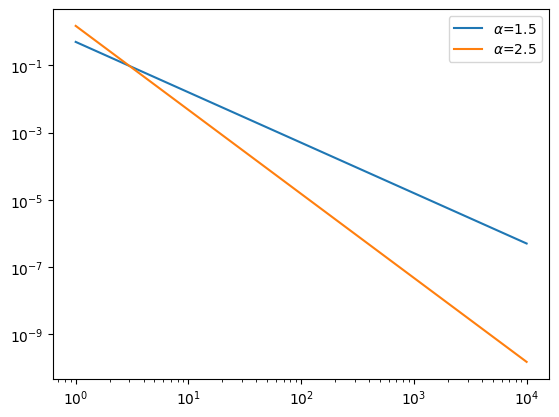

In [9]:
xx = np.linspace(1, 10**4, 100)
plt.plot(xx, powerlaw(xx, 1.5), label=r"$\alpha$=1.5")
plt.plot(xx, powerlaw(xx, 2.5), label=r"$\alpha$=2.5")
plt.xscale('log')
plt.yscale('log')
plt.legend()

#### From random numbers

In scipy.stats module, there is a class: [pareto](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pareto.html#scipy.stats.pareto) to generate Pareto continuous random variable.

> Pareto Distribution: $$P(x, b) = \frac{b}{x^{b+1}}$$ where $x \geqslant 1$ and $b>0$

In [10]:
from scipy.stats import pareto
b = 0.5 # equivalent to alpha = 1.5
r = pareto.rvs(b, size=10000) # generate 10000 random numbers from pareto distribution

Once we have the random numbers, we can compute the histogram of them by using [numpy.histogram](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)

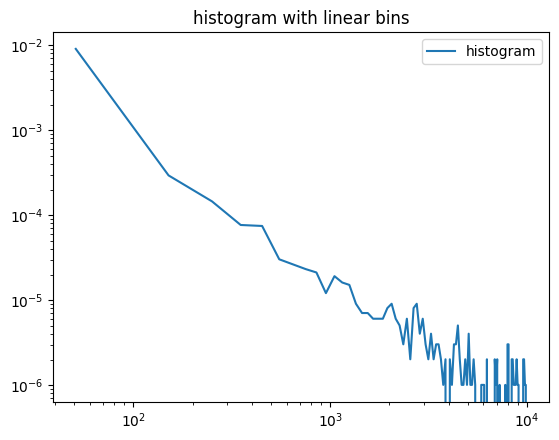

In [11]:
hist, bin_edges = np.histogram(r, bins=100, range=(1, 10000), density=True) 
# with density=True the result is the value of the probability density function at the bin
bin_center = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(bin_center, hist, label='histogram')
plt.title("histogram with linear bins")
plt.legend()
plt.xscale('log')
plt.yscale('log')

The distribution is noisy in the right-hand end of the distribution because of sampling errors. 
The power-law distribution dwindles in this region, meaning that each bin only has a few samples in it. So the fractional fluctuations in the bin counts are large and this appears as a noisy curve on the plot.
One way to deal with this is to vary the width of the bins in the histogram. The most common choice is to create bins such that each is a fixed multiple wider the one before it. This is known as `logarithmic binning`.

In [12]:
b = np.logspace(0, 3, 10)
np.log(b)

array([0.        , 0.76752836, 1.53505673, 2.30258509, 3.07011346,
       3.83764182, 4.60517019, 5.37269855, 6.14022691, 6.90775528])

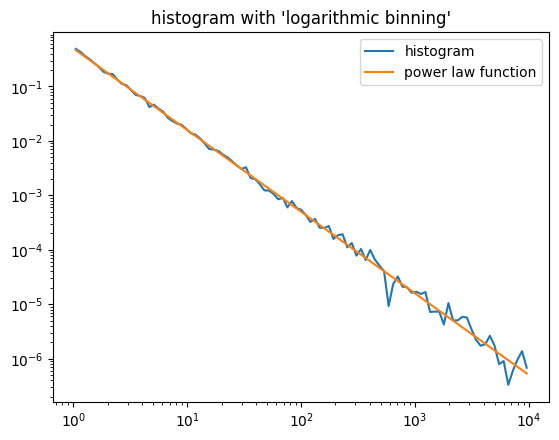

In [13]:
hist, bin_edges = np.histogram(r, bins=np.logspace(0, 4, 100), density=True) 
# with density=True the result is the value of the probability density function at the bin
bin_center = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(bin_center, hist, label='histogram')
plt.plot(bin_center, powerlaw(bin_center, 1.5), label="power law function")
plt.title("histogram with 'logarithmic binning'")
plt.legend()
plt.xscale('log')
plt.yscale('log')

## Fit a power law distribution

### polynomial fit
The simplest way to fit a histogram of power-law distribution is by using a straight line, in other words, fit the relation between log y and log x by a 1 order polynomial.

In [14]:
p = np.polyfit(np.log(bin_center), np.log(hist), deg=1)
p

array([-1.49610336, -0.70381236])

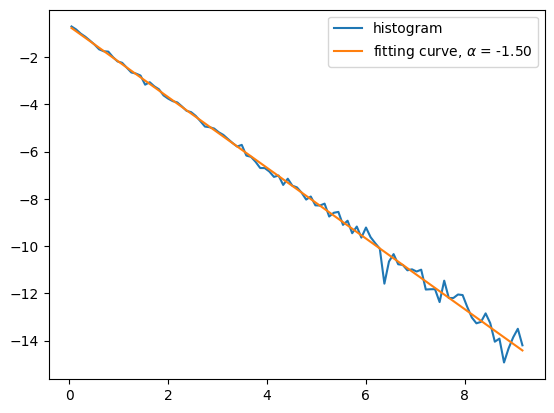

In [15]:
plt.plot(np.log(bin_center), np.log(hist), label='histogram')
plt.plot(np.log(bin_center), np.log(bin_center) * p[0] + p[1], label=f"fitting curve, $\\alpha$ = {p[0]:.2f}")
plt.legend()

# Maximum likelihood Estimation (MLE)

The simplest way to fit a Pareto distribution by MLE is using pareto.fit() directly

In [16]:
b, loc, scale = pareto.fit(r, floc=0, fscale=1)
b

0.49806330189868936

In the module scipy.stats, this `fit` function uses Maximum Likelihood Estimation (MLE) as its default estimation method.

[Maximum likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) is achieved by maximizing the conditional probability: $L(\theta | y)$, where $\theta$ is the parameter we want to estimate, and y is our observation values. This probability is called likelihood function. In other words, this method is going to find out the most likely $\theta$ under the condition that we have the measurements ${y_1, y_2, y_3, ... y_n}$

$$L(\theta|y) = \prod_n P(y_n; \theta)$$

To find out the maximum value, it's often convenient to work with the natural logarithm of the likelihood function, called log-likelihood:
$$l(\theta|y) = \sum_n \log{ P(y_n; \theta)}$$
Then solve the equation:
$$\frac{\partial l}{\partial \theta}=0$$

So for Power law distribution:
$$P(x; b) = C x^{-\alpha}$$
where $C=(\alpha-1)/x_{min}^{1-\alpha}$

In [17]:
y = sympy.IndexedBase('y', positive=True)
i, n, b = sympy.symbols('i n b', positive=True)
P = P.subs(x, y[i])
log_L = sympy.Sum(sympy.log(P), (i, 1, n)) # l = sum of log(P(x))
log_L

Sum(log(x_{min}**(alpha - 1)*(alpha - 1)/y[i]**alpha), (i, 1, n))

In [18]:
dldb = log_L.diff(alpha)
dldb

Sum(x_{min}**(1 - alpha)*(x_{min}**(alpha - 1)*(alpha - 1)*log(x_{min})/y[i]**alpha - x_{min}**(alpha - 1)*(alpha - 1)*log(y[i])/y[i]**alpha + x_{min}**(alpha - 1)/y[i]**alpha)*y[i]**alpha/(alpha - 1), (i, 1, n))

In [19]:
dldb = log_L.diff(alpha)
dldb = sympy.simplify(dldb * (alpha-1))
dldb

n*(alpha - 1)*log(x_{min}) + n + (1 - alpha)*Sum(log(y[i]), (i, 1, n))

So:
$$\frac{\partial l}{\partial b}=0$$
$$n(\alpha-1)\log{x_{min}}+n+(1-\alpha)\sum_i \log{y_i} = 0$$

In [20]:
sympy.solve(dldb, alpha)[0]

(n*log(x_{min}) - n - Sum(log(y[i]), (i, 1, n)))/(n*log(x_{min}) - Sum(log(y[i]), (i, 1, n)))

Finally we get:
$$\alpha = \frac{n\log{x_{min}-n-\sum_i\log{y_i}}}{n\log{x_{min}-\sum_i \log{y_i}}} = 1 + \frac{n}{\sum_i\log{y_i}-n\log{x_{min}}}$$

With maximum likelihood, we can get Akaike information criterion (AIC), which is an estimator of prediction error and thereby relative quality of statistical models for a given set of data.

## Exercise 01
 ***1.	Ask ChatGPT questions about Power Laws (The questions that you are interest in)***
 
 The grade will be based on the question you asked. More specific, more interesting questions will get more points.
 
> Bad example:
> What is power law distribution? or Write me a 50 words summary of power-law

How do power laws, which are ubiquitous in natural and social systems, arise and manifest themselves in different contexts, and how can we use them to understand and predict the behavior of complex systems, while also addressing the criticisms and limitations of their use in modeling real-world phenomena? Limit your answer to 200 words



Power laws are a type of mathematical relationship that describe how one variable changes with respect to another. They are ubiquitous in natural and social systems and can manifest themselves in a variety of contexts, such as the distribution of city sizes, the frequency of words in a language, the size of earthquakes, and the popularity of websites.

The emergence of power laws in complex systems is often attributed to processes that involve feedback and preferential attachment, where the probability of a new node connecting to an existing node increases with the number of connections that node already has. This leads to a rich-get-richer phenomenon, where a few nodes become highly connected while most others remain relatively isolated.

Power laws can be used to understand and predict the behavior of complex systems, as they provide insights into the underlying mechanisms that generate the observed patterns. They can also be used to design more efficient and robust systems, by identifying the critical nodes that are most important for maintaining connectivity and resilience.

However, there are also criticisms and limitations of their use in modeling real-world phenomena. One criticism is that power laws are often based on data that are incomplete or biased, leading to incorrect inferences about the underlying processes. Another limitation is that power laws are descriptive rather than explanatory, providing little insight into the causal mechanisms that give rise to the observed patterns.

To address these limitations, researchers have developed more sophisticated models that incorporate additional factors such as network structure, heterogeneity, and dynamics. These models can provide a more nuanced understanding of the underlying processes and help to identify the critical factors that shape the behavior of complex systems.



What kind of additional factors should we incorporate? Limit your answer to  200 words

To develop more accurate and nuanced models that address the limitations of power laws, researchers have proposed incorporating additional factors such as network structure, heterogeneity, and dynamics.

Network structure refers to the way in which nodes are connected in a system. Different types of networks, such as scale-free, small-world, and random networks, can lead to different patterns of behavior and emergence of power laws. Incorporating network structure into models can help to identify the critical nodes that are most important for maintaining connectivity and resilience, and can also provide insights into the spread of information or disease through the network.

Heterogeneity refers to the differences that exist between nodes in a system, such as in their degree of connectivity, influence, or susceptibility to certain factors. Incorporating heterogeneity into models can help to explain why some nodes are more critical than others, and can also help to predict how the system will respond to different types of perturbations.

Dynamics refers to the way in which systems change over time, such as through growth, decay, or adaptation. Incorporating dynamics into models can help to capture the evolution of power laws over time, and can also help to predict how the system will respond to changing conditions or perturbations.

Overall, incorporating network structure, heterogeneity, and dynamics into models can provide a more nuanced understanding of the underlying processes that give rise to power laws in complex systems, and can help to identify critical factors that shape the behavior of these systems.







***2.Reproduce all three figures on slide 9 using $\alpha$=1.6,2.2 and 3.1.***
> generate random numbers by using scipy.stats.pareto.rvs(b, size)

> make a log-log plot

> If first and/or second moments exist, draw the theoretical value as dashed line.

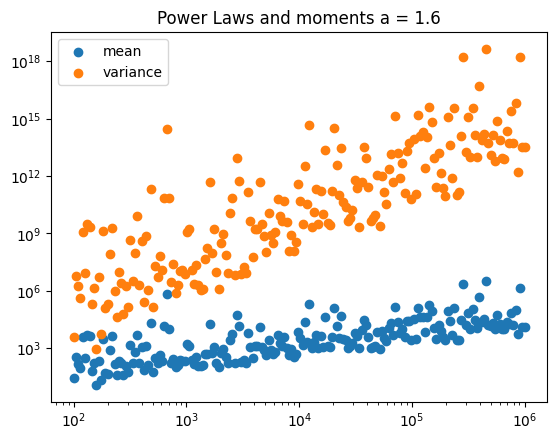

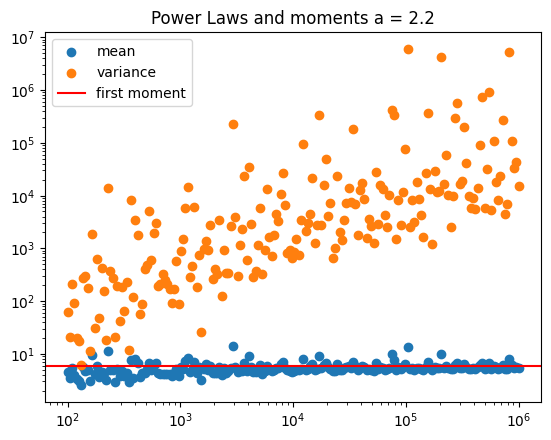

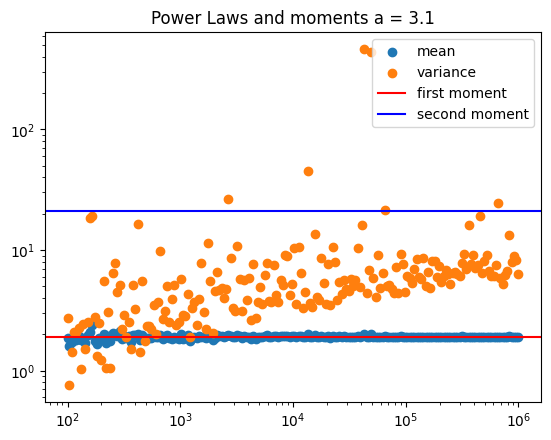

In [21]:
import scipy
means = []
vars = []
f_ms=[]
s_ms=[]
for b in [0.6,1.2,2.1]:
  X = np.logspace(np.log10(100), np.log10(10**6), 200, dtype=int)
  mean = []
  var = []
  for x in X:
    Y = scipy.stats.pareto.rvs(b,size=x)
    mean.append(np.mean(Y))
    var.append(np.var(Y))
  f_m = (b/(b-1))*min(Y)**1
  s_m = (b/(b-2))*min(Y)**2
  means.append(mean)
  vars.append(var)
  

  plt.title(f"Power Laws and moments a = {b+1}")
  plt.xscale('log')
  plt.yscale('log')
  plt.scatter(X, mean, label='mean')
  plt.scatter(X, var, label = 'variance')
  if f_m >0:
    plt.axhline(y=f_m, color='r', linestyle='-', label='first moment')
  if s_m > 0:
    plt.axhline(y=s_m, color='b', linestyle='-',label = 'second moment')
  plt.legend()

  plt.show()


***3.Reproduce Zipf’s law by sample-space-reducing (SSR) processes; fit the historgram to determine the power-law exponent***

**SSR processes**
The simple sample space reducing (SSR) process could be illustrated by a set of N fair dice with different number of faces. The first has one face, the second has two faces and so on to the N-th that has N faces. To start the process we take the dice with N faces and throw it, getting a result K. Then we throw the dice with K-1 faces getting a new result. Once we reach the dice with one face we restart the process by throwing the N-faced dice again. In an equivalent way, we can interpret the process considering a staircase with N steps: imagine a ball that randomly falls downstairs but never can climb to higher levels. The ball first hits any of the N steps with uniform probability, $P_N(i)=1/N$
, $i=1\dots N$
. Then it can only fall down to a lower level with uniform probability and so on until it reaches the bottom step. Once landed on the first step, it restart jumping randomly to any of the steps.
![SSR](https://camo.githubusercontent.com/0be72accd87b164732ddbd4b0d065387ae459238245a9055106c4d4c5d07ca62/68747470733a2f2f7777772e706e61732e6f72672f636d732f31302e313037332f706e61732e313432303934363131322f61737365742f35353366383738612d323933302d343463332d396139632d3366343832663739653633362f6173736574732f677261706869632f706e61732e3134323039343631313266696730312e6a706567)
and the occupation probability, i.e. how often a given site i is occupied on average should be:


$$P(i) = \frac{c}{i}$$

**Fit the histogram**
For checking whether your result obeys $P(i) = \frac{c}{i}$ or not, please find the exponent by polynomial fit.

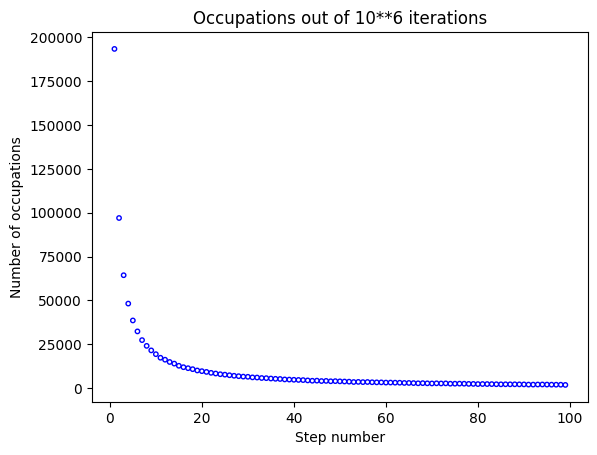

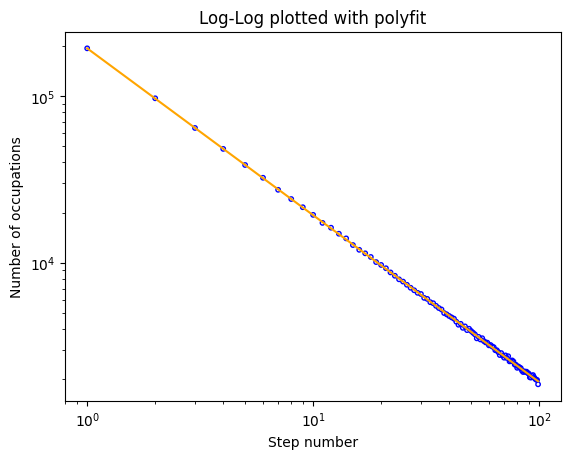

The parameter is: -1.0006028741032251


In [22]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
counter = np.zeros(N-1)
current = N

for i in range(10**6):
    current = np.random.randint(1, current)
    counter[current-1] += 1
    if current == 1:
        current = N

plt.scatter(range(1, N), counter, s=10, facecolors='none', edgecolors='b', label='Sample variance')
plt.title('Occupations out of 10**6 iterations')
plt.xlabel('Step number')
plt.ylabel('Number of occupations')
plt.show()

fitter = np.polyfit(np.log(np.arange(1, N)), np.log(counter), deg=1)
plt.scatter(range(1, N), counter, s=10, facecolors='none', edgecolors='b', label='Sample variance')
plt.plot(range(1, N), np.exp(fitter[1]) * range(1, N) ** fitter[0], c='orange')
plt.title('Log-Log plotted with polyfit')
plt.xlabel('Step number')
plt.ylabel('Number of occupations')
plt.xscale('log')
plt.yscale('log')
plt.show()

print('The parameter is:', fitter[0])
